In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
! conda install -y gdown 

Retrieving notices: ...working... done
Channels:
 - rapidsai
 - nvidia
 - nodefaults
 - conda-forge
 - defaults
 - pytorch
Platform: linux-64
Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-24.9.1               |  py310hff52083_0         894 KB  conda-forge
    filelock-3.16.1            |     pyhd8ed1ab_0          17 KB  conda-forge
    gdown-5.2.0                |     pyhd8ed1ab_0          21 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         932 KB

The following NEW packages will be INSTALLED:

  filelock           conda-forge/noa

In [3]:
!gdown --id 1_LV_BzhPSkGORg0VTJoywu0CzlTNpKMk  

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1_LV_BzhPSkGORg0VTJoywu0CzlTNpKMk
To: /kaggle/working/Time Series.zip
100%|███████████████████████████████████████| 8.48M/8.48M [00:00<00:00, 109MB/s]


In [4]:
import zipfile
z= zipfile.ZipFile('Time Series.zip')
z.extractall()

In [5]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout,BatchNormalization,LayerNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
import matplotlib.pyplot as plt
from keras.optimizers import Adam

In [6]:
# Load the dataset (assuming it's already preprocessed)
df = pd.read_csv('/kaggle/working/train-00000-of-00001-0866b62cb4c6a541.csv')  # Replace with actual path or data loading logic
df = df[['open', 'high', 'low', 'close', 'volume']]  # Feature selection

In [7]:
# Check for and handle missing values
print(df.isnull().sum())  # Print the number of missing values per column

open      407
high      407
low       407
close     407
volume    406
dtype: int64


In [8]:
# Drop rows with any missing values (you can also choose to fill them instead)
df = df.dropna()

In [9]:
# Normalize/scale the input features and target variable
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

In [10]:
x = scaler_x.fit_transform(df[['open', 'high', 'low', 'volume']])
y = scaler_y.fit_transform(df[['close']])

In [11]:
# Reshape the input to be [samples, time steps, features]
time_step = 60
x_data = []
y_data = []

for i in range(time_step, len(df)):
    x_data.append(x[i-time_step:i])
    y_data.append(y[i])

x, y = np.array(x_data), np.array(y_data)

In [12]:
# Split into training, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [13]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.4))  # Increased dropout to 30%
model.add(LayerNormalization())
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.4))  # Increased dropout to 30%
model.add(LayerNormalization())
model.add(Dense(units=25))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
model.add(Dense(units=1))

In [15]:
# Compile the model with gradient clipping and a reduced learning rate
model.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=1.0), loss='huber', )

In [16]:
# Add early stopping and learning rate reduction on plateau callbacks

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Train the model with early stopping and learning rate reduction
history = model.fit(x_train, y_train, 
                    validation_data=(x_val, y_val),
                    epochs=100, 
                    batch_size=32, 
                    callbacks=[early_stopping, reduce_lr, checkpoint])

Epoch 1/100
7553/7553 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0021
Epoch 1: val_loss improved from inf to 0.00000, saving model to best_model.keras
7553/7553 ━━━━━━━━━━━━━━━━━━━━ 88s 11ms/step - loss: 0.0021 - val_loss: 1.8715e-06 - learning_rate: 1.0000e-04
Epoch 2/100
7550/7553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.3469e-06
Epoch 2: val_loss improved from 0.00000 to 0.00000, saving model to best_model.keras
7553/7553 ━━━━━━━━━━━━━━━━━━━━ 86s 11ms/step - loss: 5.3479e-06 - val_loss: 1.4811e-06 - learning_rate: 1.0000e-04
Epoch 3/100
7552/7553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0014e-05
Epoch 3: val_loss did not improve from 0.00000
7553/7553 ━━━━━━━━━━━━━━━━━━━━ 87s 12ms/step - loss: 1.0013e-05 - val_loss: 1.1547e-05 - learning_rate: 1.0000e-04
Epoch 4/100
7551/7553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.4027e-06
Epoch 4: val_loss did not improve from 0.00000
7553/7553 ━━━━━━━━━━━━━━━━━━━━ 87s 12ms/step - loss: 5.4026e-06 - val_loss: 5.7536e-06 - learning_rate:

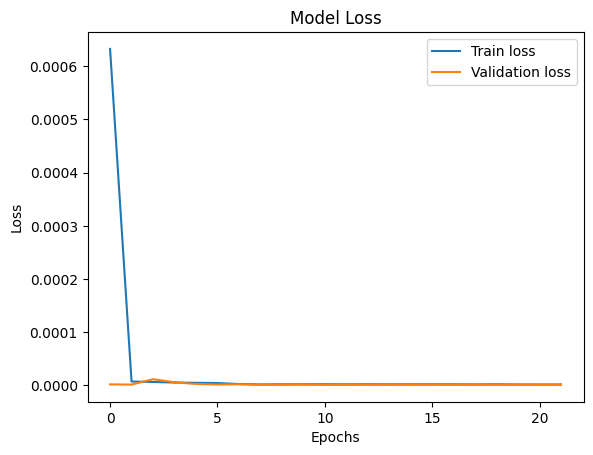

In [17]:
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

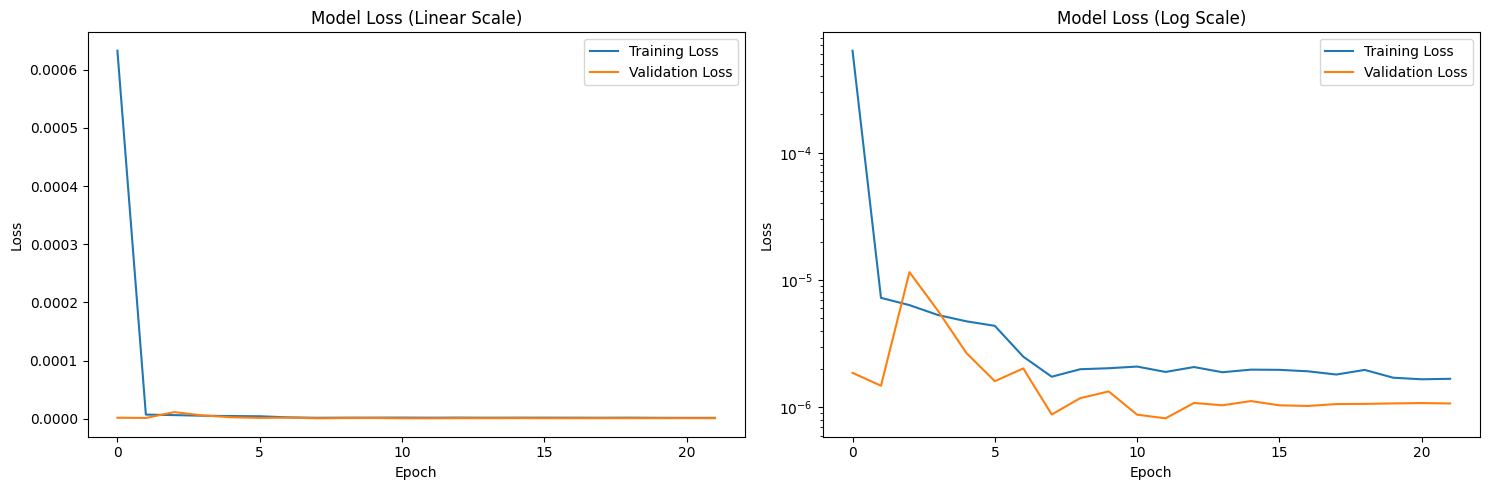

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
# Linear scale plot
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Model Loss (Linear Scale)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
    
# Log scale plot
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss (Log Scale)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_yscale('log')
ax2.legend()
    
plt.tight_layout()
plt.show()

In [19]:
# Evaluate the model on the test set
val_loss = model.evaluate(x_test, y_test)
print(f'Validation Loss: {val_loss}')

2361/2361 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 3.6449e-07
Validation Loss: 8.033435960896895e-07


In [20]:
# Make predictions
y_pred = model.predict(x_test)

2361/2361 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


In [21]:
# Inverse transform the predictions and the true values to their original scale
y_pred = scaler_y.inverse_transform(y_pred)
y_test = scaler_y.inverse_transform(y_test)

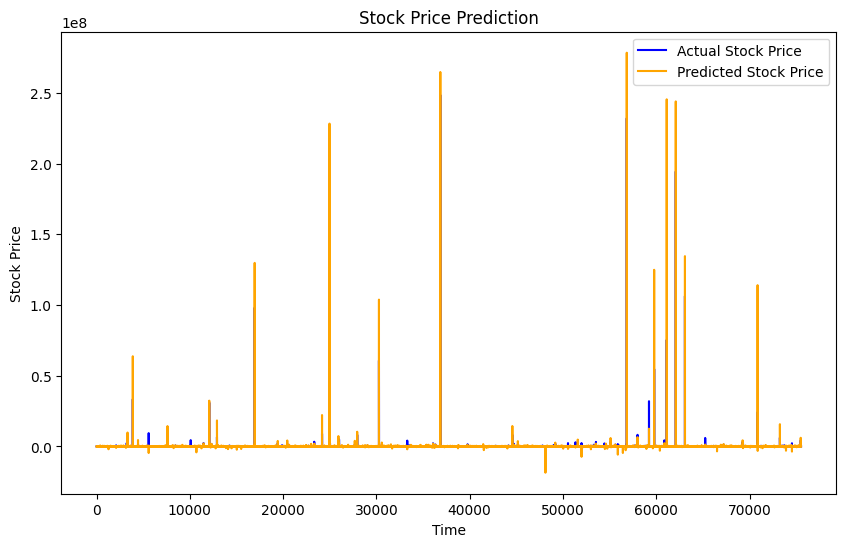

In [22]:
# Visualize the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test, color='blue', label='Actual Stock Price')
plt.plot(y_pred, color='orange', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

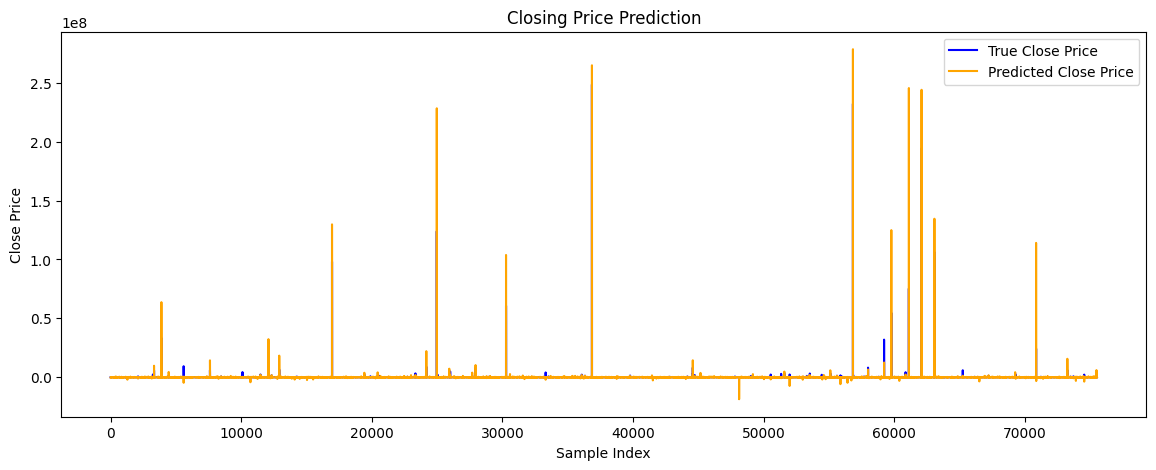

In [23]:
# Plot the predictions vs true values
plt.figure(figsize=(14, 5))
plt.plot(range(len(y_test)), y_test, color='blue', label='True Close Price')
plt.plot(range(len(y_pred)), y_pred, color='orange', label='Predicted Close Price')
plt.title('Closing Price Prediction')
plt.xlabel('Sample Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared Score: {r2:.4f}")

Mean Absolute Error: 36216.4352
Root Mean Squared Error: 924045.2613
R-squared Score: 0.6878
